In [0]:
#Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#Import data preprocessing, data split, metrics libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,explained_variance_score
#import ensemble learners
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgbo
#import cross validation libraries
from sklearn import model_selection
from sklearn.model_selection import KFold
#Import statistical libraries to plot distribution of data
from scipy import stats
from scipy.stats import norm, skew
#import warnings to supress if any
import warnings
warnings.filterwarnings('ignore')
#Common settings for sns plots
sns.set(style='white', context='notebook', palette='deep',font_scale=1)
#import files to colab
from google.colab import files 

In [4]:

uploaded = files.upload() 

Saving CrimeMerged.csv to CrimeMerged.csv


In [5]:
crime = pd.read_csv('CrimeMerged.csv')
crime.shape #(33565, 28)
crime.dtypes
#Convert all categories to object datatype
crime.Year = crime.Year.astype(object)
crime.Month = crime.Month.astype(object)
crime.WEEKDAY = crime.WEEKDAY.astype(object)
crime.Holiday = crime.Holiday.astype(object) 
crime = crime.drop(columns='Day') # Drop unwanted column
crime.isna().sum() #Check for NA values

geohash                         0
Primary_Type                    0
Year                            0
Month                           0
WEEKDAY                         0
Holiday                         0
Time                            0
crimescount                     0
NearestPoliceDist               0
NearestSpeedCamDist             0
NearestRedCamDist               0
SpeedCamCount                   0
RedCamCount                     0
Avg_Misconduct_Rate             0
Avg_Suspension_Rate             0
Avg_Student_Attendance_Rate     0
Avg_Teacher_Attendance_Rate     0
Avg_Suspension_Days             0
SchoolCount                     0
Avg_Dropout_Rate                0
Avg_FreshmanTrack_Rate          0
Avg_CollegeEnrollment_Rate      0
Avg_College_Persistence_Rate    0
Mobility_Rate_Pct               0
avgTemp                         0
prcp                            0
wind                            0
dtype: int64

In [6]:
crime.dtypes

geohash                          object
Primary_Type                     object
Year                             object
Month                            object
WEEKDAY                          object
Holiday                          object
Time                             object
crimescount                       int64
NearestPoliceDist               float64
NearestSpeedCamDist             float64
NearestRedCamDist               float64
SpeedCamCount                   float64
RedCamCount                     float64
Avg_Misconduct_Rate             float64
Avg_Suspension_Rate             float64
Avg_Student_Attendance_Rate     float64
Avg_Teacher_Attendance_Rate     float64
Avg_Suspension_Days             float64
SchoolCount                     float64
Avg_Dropout_Rate                float64
Avg_FreshmanTrack_Rate          float64
Avg_CollegeEnrollment_Rate      float64
Avg_College_Persistence_Rate    float64
Mobility_Rate_Pct               float64
avgTemp                         float64


In [7]:
crime.head()

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Avg_Suspension_Days,SchoolCount,Avg_Dropout_Rate,Avg_FreshmanTrack_Rate,Avg_CollegeEnrollment_Rate,Avg_College_Persistence_Rate,Mobility_Rate_Pct,avgTemp,prcp,wind
0,dp3sy,ASSAULT,2015,1,0,False,afternoon,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677
1,dp3sy,ASSAULT,2015,1,0,False,evening,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677
2,dp3sy,ASSAULT,2015,1,0,False,morning,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677
3,dp3sy,ASSAULT,2015,1,0,False,night,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677
4,dp3sy,ASSAULT,2015,1,1,False,evening,1,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677


In [8]:
crime.Year.value_counts()

2015    8772
2018    8366
2016    8268
2017    8159
Name: Year, dtype: int64

In [0]:
narcotics = crime.copy()

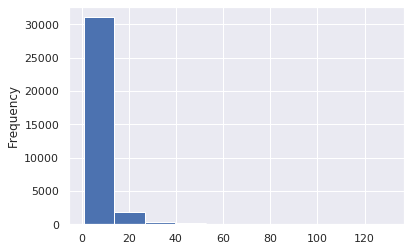

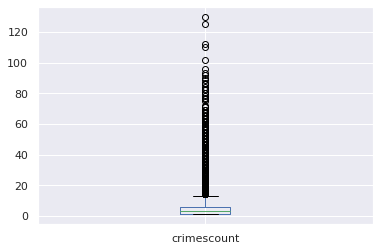

In [12]:
#We will plot our dependent variable, crime rate for its distribution and outliers
sns.set(font_scale=1)
narcotics['crimescount'].plot(kind='hist')
plt.show() #Right skewed which means positively skewed
narcotics.boxplot(column=['crimescount'],return_type='axes')
#we will check whether log transformation changes the skewness

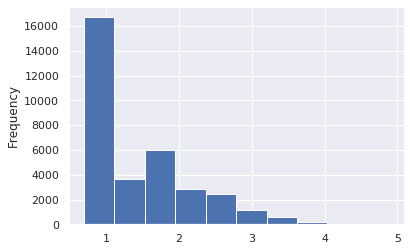

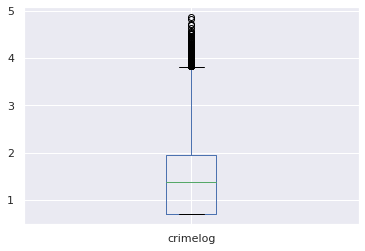

In [13]:
#After log transformation, check the distribution
narcotics['crimelog'] = np.log1p(narcotics['crimescount'])
narcotics['crimelog'].plot(kind='hist')
plt.show() #Right skewed which means positively skewed
narcotics.boxplot(column=['crimelog'],return_type='axes')
#Even after log transformation, not much of a change
#Since ensemble learners RF & XGB do not carry any assumption about distribution, we will use the original crime count variable

In [14]:
narcotics.head()

,geohash,Primary_Type,Year,Month,WEEKDAY,Holiday,Time,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Avg_Suspension_Days,SchoolCount,Avg_Dropout_Rate,Avg_FreshmanTrack_Rate,Avg_CollegeEnrollment_Rate,Avg_College_Persistence_Rate,Mobility_Rate_Pct,avgTemp,prcp,wind,crimelog
0,dp3sy,ASSAULT,2015,1,0,False,afternoon,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1.386294
1,dp3sy,ASSAULT,2015,1,0,False,evening,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1.386294
2,dp3sy,ASSAULT,2015,1,0,False,morning,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1.098612
3,dp3sy,ASSAULT,2015,1,0,False,night,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1.098612
4,dp3sy,ASSAULT,2015,1,1,False,evening,1,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,0.693147


In [0]:
#Defining plots for multiple visualizations
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

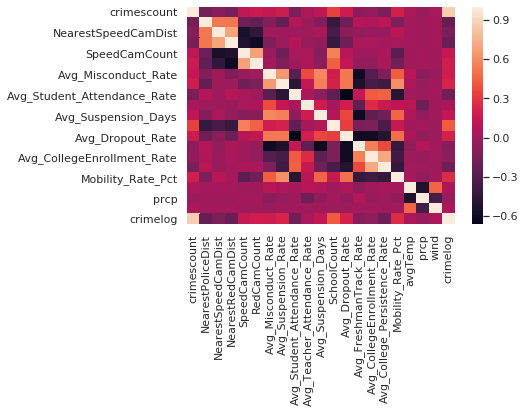

In [16]:
#Check correlations
narcotics.corr()
sns.set(font_scale=1)
g = sns.heatmap(narcotics.corr())

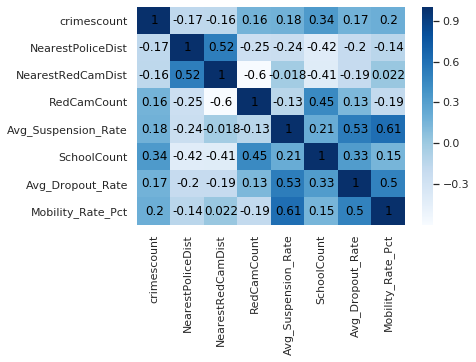

In [17]:
#Data shows weak linear correlation 
narcotics_new = narcotics.drop(columns='crimelog')
corrmat =narcotics_new.corr()
#Display variables having correlation value above 0.15
top_corr_features = corrmat.index[abs(corrmat["crimescount"])>0.15]
g = sns.heatmap(narcotics_new[top_corr_features].corr(),annot=True,cmap="Blues",annot_kws={"color": 'black'})

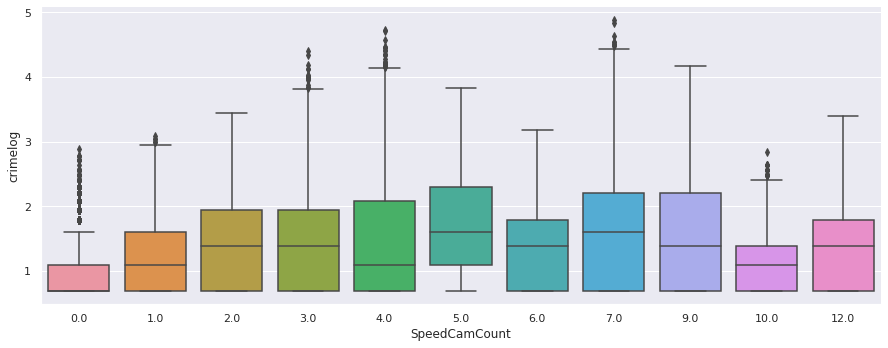

In [18]:
#We will use the log scale to plot the factor plots
g = sns.factorplot(x="SpeedCamCount",y="crimelog",data=narcotics,kind='box',aspect=2.5)

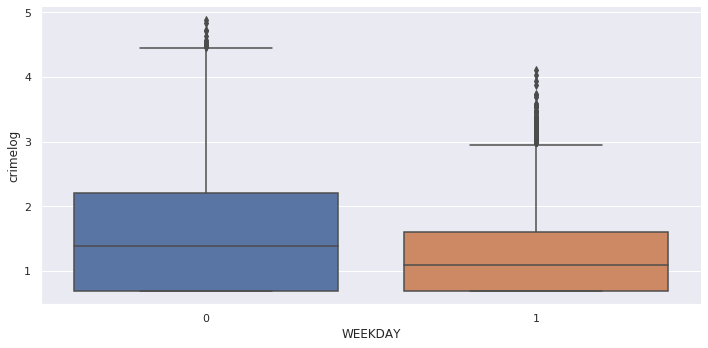

In [20]:
g = sns.factorplot(x="WEEKDAY",y="crimelog",data=narcotics,kind='box',aspect=2)
#Shows weekend has more crime count

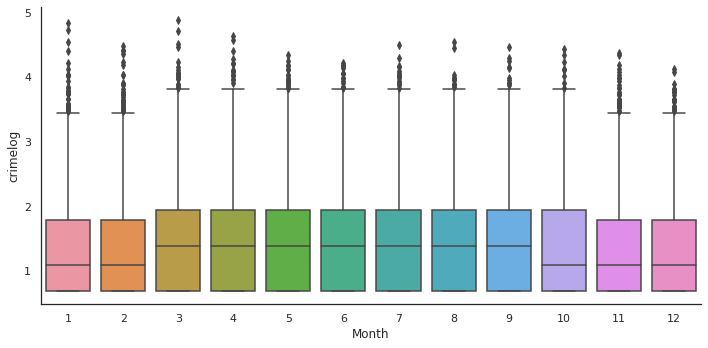

In [33]:
g = sns.factorplot(x="Month",y="crimelog",data=narcotics,kind='box',aspect=2)
#High in first quarter

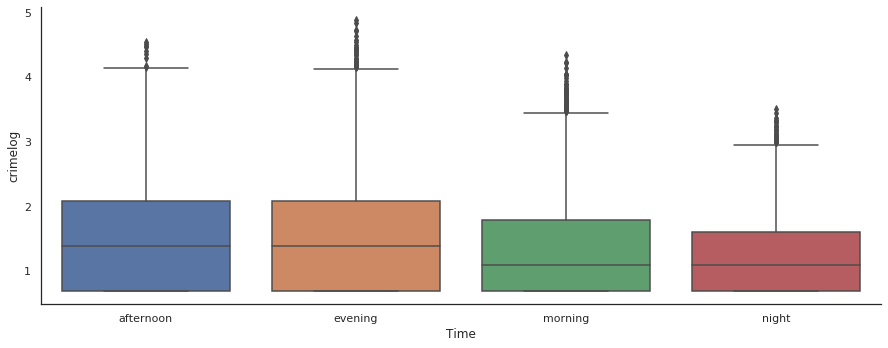

In [34]:
g = sns.factorplot(x="Time",y="crimelog",data=narcotics,kind='box',aspect=2.5)
#High in evening and afternoon compared to morning and night

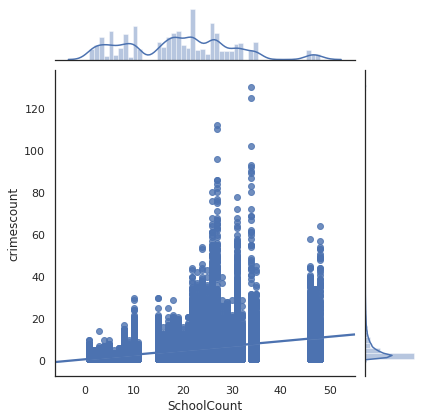

In [28]:
g = sns.jointplot(x = narcotics['SchoolCount'], y = narcotics['crimescount'],kind="reg")

In [0]:
#sns.pairplot(narcotics) #takes a lot of time, hence commented

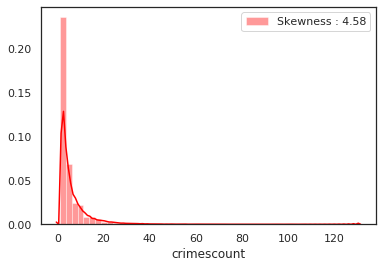

In [27]:
g = sns.distplot(narcotics['crimescount'],color="red")
g = g.legend(['Skewness : {:.2f}'.format(narcotics['crimescount'].skew())],loc='best')
#Distribution in the form of distribution plot using sns

In [35]:
narcotics.columns

Index(['geohash', 'Primary_Type', 'Year', 'Month', 'WEEKDAY', 'Holiday',
       'Time', 'crimescount', 'NearestPoliceDist', 'NearestSpeedCamDist',
       'NearestRedCamDist', 'SpeedCamCount', 'RedCamCount',
       'Avg_Misconduct_Rate', 'Avg_Suspension_Rate',
       'Avg_Student_Attendance_Rate', 'Avg_Teacher_Attendance_Rate',
       'Avg_Suspension_Days', 'SchoolCount', 'Avg_Dropout_Rate',
       'Avg_FreshmanTrack_Rate', 'Avg_CollegeEnrollment_Rate',
       'Avg_College_Persistence_Rate', 'Mobility_Rate_Pct', 'avgTemp', 'prcp',
       'wind', 'crimelog'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

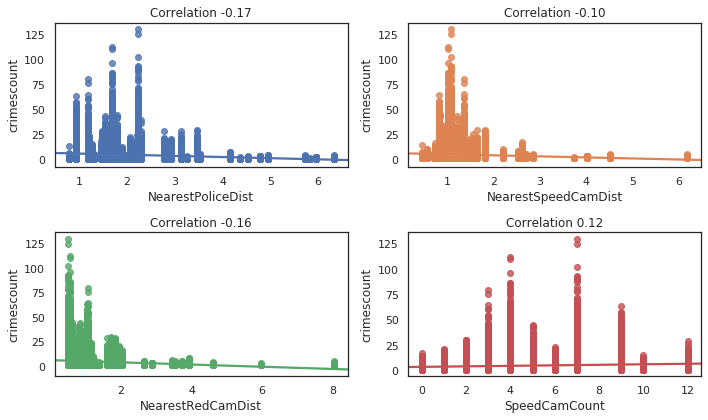

<Figure size 432x288 with 0 Axes>

In [36]:
feats = ['NearestPoliceDist', 'NearestSpeedCamDist', 'NearestRedCamDist',
       'SpeedCamCount', 'RedCamCount']

multiplot(data = narcotics,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = "crimescount", colorize = True)

<Figure size 432x288 with 0 Axes>

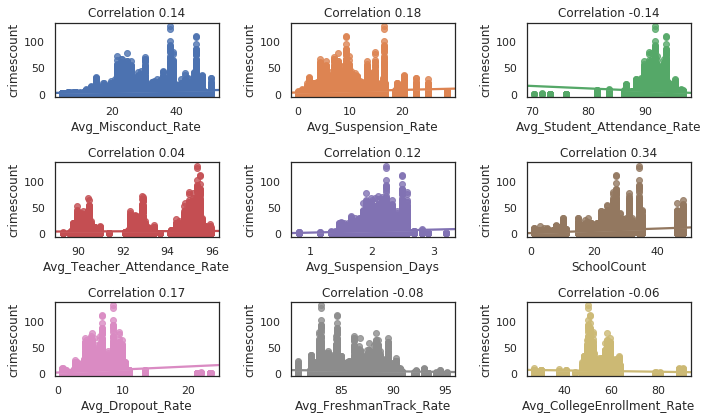

<Figure size 432x288 with 0 Axes>

In [37]:
feats = ['Avg_Misconduct_Rate',
       'Avg_Suspension_Rate', 'Avg_Student_Attendance_Rate',
       'Avg_Teacher_Attendance_Rate', 'Avg_Suspension_Days', 'SchoolCount',
       'Avg_Dropout_Rate', 'Avg_FreshmanTrack_Rate',
       'Avg_CollegeEnrollment_Rate', 'Avg_College_Persistence_Rate',
       'Mobility_Rate_Pct']

multiplot(data = narcotics,features = feats,plottype = "regplot",nrows = 3, ncols = 3,
          figsize = (10,6),y = "crimescount", colorize = True)

<Figure size 432x288 with 0 Axes>

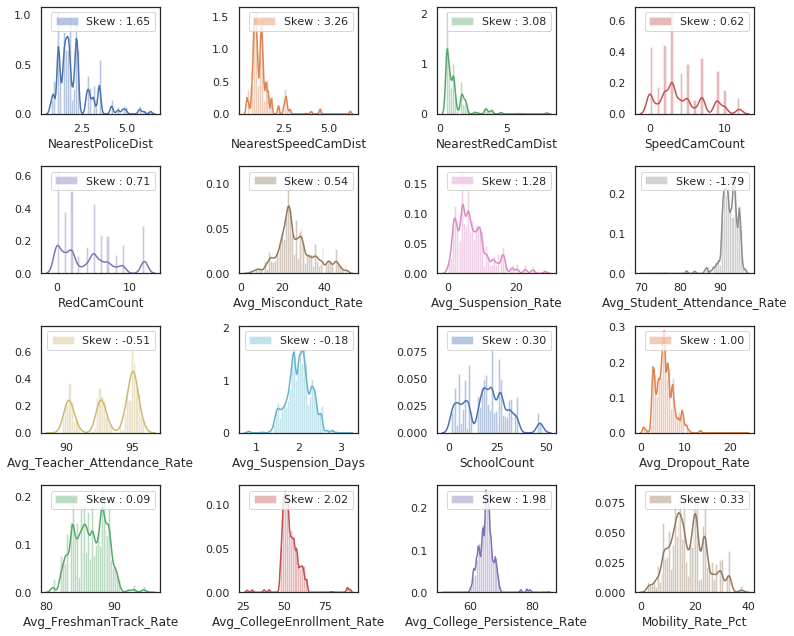

<Figure size 432x288 with 0 Axes>

In [38]:
#all features skewness check
features = [ 'NearestPoliceDist', 'NearestSpeedCamDist', 'NearestRedCamDist',
       'SpeedCamCount', 'RedCamCount', 'Avg_Misconduct_Rate',
       'Avg_Suspension_Rate', 'Avg_Student_Attendance_Rate',
       'Avg_Teacher_Attendance_Rate', 'Avg_Suspension_Days', 'SchoolCount',
       'Avg_Dropout_Rate', 'Avg_FreshmanTrack_Rate',
       'Avg_CollegeEnrollment_Rate', 'Avg_College_Persistence_Rate',
       'Mobility_Rate_Pct']
multiplot(data = narcotics,features = features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

<Figure size 432x288 with 0 Axes>

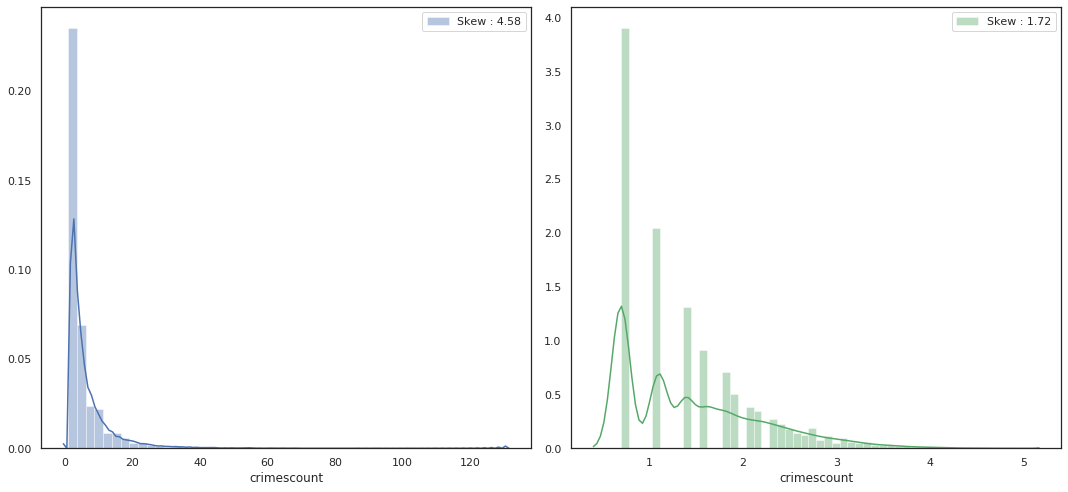

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(narcotics["crimescount"],ax = axes[0])
sns.distplot(np.log1p(narcotics["crimescount"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(narcotics["crimescount"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(narcotics["crimescount"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

Without Feature Selection


In [42]:
narcotics = narcotics.drop(columns='crimelog')
narcotics_dummies = pd.get_dummies(narcotics)
narcotics_dummies.head() #95 columns

,crimescount,NearestPoliceDist,NearestSpeedCamDist,NearestRedCamDist,SpeedCamCount,RedCamCount,Avg_Misconduct_Rate,Avg_Suspension_Rate,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Avg_Suspension_Days,SchoolCount,Avg_Dropout_Rate,Avg_FreshmanTrack_Rate,Avg_CollegeEnrollment_Rate,Avg_College_Persistence_Rate,Mobility_Rate_Pct,avgTemp,prcp,wind,geohash_dp3sy,geohash_dp3sz,geohash_dp3t5,geohash_dp3t7,geohash_dp3td,geohash_dp3te,geohash_dp3tf,geohash_dp3tg,geohash_dp3th,geohash_dp3tj,geohash_dp3tk,geohash_dp3tm,geohash_dp3tn,geohash_dp3tp,geohash_dp3tq,geohash_dp3tr,geohash_dp3ts,geohash_dp3tt,geohash_dp3tu,geohash_dp3tv,...,geohash_dp3wh,geohash_dp3wj,geohash_dp3wk,geohash_dp3wm,geohash_dp3wn,geohash_dp3wq,geohash_dp3ws,geohash_dp3wt,geohash_dp3wu,geohash_dp3wv,geohash_dp3x1,geohash_dp3xh,Primary_Type_ASSAULT,Primary_Type_HOMICIDE,Primary_Type_NARCOTICS,Primary_Type_VIOLATIONS,Year_2015,Year_2016,Year_2017,Year_2018,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,WEEKDAY_0,WEEKDAY_1,Holiday_False,Holiday_True,Time_afternoon,Time_evening,Time_morning,Time_night
0,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
1,3,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,2,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
4,1,4.16,2.52,3.93,0.0,0.0,41.23,10.12,92.83,94.57,2.81,5.0,4.57,85.48,51.93,65.79,26.88,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0


In [0]:
model_data = narcotics_dummies.values
X = model_data[:,1:]
Y = model_data[:,0]
np.random.seed(67)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

In [0]:
#list(narcotics_dummies.columns) (Big output cell)

In [48]:
#Random Forest for feature selection on data without feature selection
feat_labels = ['NearestPoliceDist',
 'NearestSpeedCamDist','NearestRedCamDist','SpeedCamCount','RedCamCount','Avg_Misconduct_Rate','Avg_Suspension_Rate','Avg_Student_Attendance_Rate',
 'Avg_Teacher_Attendance_Rate','Avg_Suspension_Days','SchoolCount','Avg_Dropout_Rate','Avg_FreshmanTrack_Rate','Avg_CollegeEnrollment_Rate','Avg_College_Persistence_Rate',
 'Mobility_Rate_Pct','avgTemp','prcp','wind',
 'geohash_dp3sy','geohash_dp3sz','geohash_dp3t5','geohash_dp3t7','geohash_dp3td','geohash_dp3te',
 'geohash_dp3tf','geohash_dp3tg','geohash_dp3th','geohash_dp3tj','geohash_dp3tk','geohash_dp3tm',
 'geohash_dp3tn','geohash_dp3tp','geohash_dp3tq','geohash_dp3tr','geohash_dp3ts','geohash_dp3tt',
 'geohash_dp3tu','geohash_dp3tv','geohash_dp3tw','geohash_dp3tx','geohash_dp3ty','geohash_dp3v0',
 'geohash_dp3v2','geohash_dp3w4','geohash_dp3w5','geohash_dp3w6','geohash_dp3w7','geohash_dp3w9',
 'geohash_dp3wc','geohash_dp3wd','geohash_dp3we','geohash_dp3wf','geohash_dp3wg','geohash_dp3wh',
 'geohash_dp3wj','geohash_dp3wk','geohash_dp3wm','geohash_dp3wn','geohash_dp3wq','geohash_dp3ws',
 'geohash_dp3wt','geohash_dp3wu','geohash_dp3wv','geohash_dp3x1','geohash_dp3xh',
 'Primary_Type_ASSAULT','Primary_Type_HOMICIDE','Primary_Type_NARCOTICS','Primary_Type_VIOLATIONS','Year_2015','Year_2016','Year_2017','Year_2018',
 'Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12','WEEKDAY_0','WEEKDAY_1','Holiday_False','Holiday_True',
 'Time_afternoon','Time_evening','Time_morning','Time_night']
clf = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
# Train the classifier
clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

In [50]:
y_pred = clf.predict(X_test)
# View The Accuracy Of all features (95 Features) Model
print("Variance Score is", explained_variance_score(y_pred,Y_test))
print('R2:',clf.score(X_test,Y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Variance Score is 0.7907655294916491
R2: 0.8106969832374175
Mean Absolute Error: 1.6482347683598988
Mean Squared Error: 7.626843438105169
Root Mean Squared Error: 2.76167402821281


In [51]:
#XGBoost
xgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train,Y_train)
predictions = xgb.predict(X_test)
print("Variance Score is", explained_variance_score(predictions,Y_test))
print("R2 ",r2_score(Y_test, predictions))
print("MAE ", mean_absolute_error(Y_test, predictions))
print("MSE ",mean_squared_error(Y_test,predictions))
print("RMSE is",np.sqrt(mean_squared_error(Y_test,predictions))) 

[19:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Variance Score is 0.414482912358227
R2  0.6879765035086562
MAE  2.122428864129659
MSE  12.5711380486569
RMSE is 3.545580072238801


Top 20 features

In [0]:
X = narcotics_dummies.drop('crimescount',axis=1)
Y = narcotics_dummies.crimescount
colnames = narcotics_dummies.columns

In [0]:
from sklearn.preprocessing import MinMaxScaler
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [0]:
# Construct our Linear Regression model
from sklearn.feature_selection import RFE
rr = RandomForestRegressor()
rr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(rr, n_features_to_select=20, verbose =3 )
rfe.fit(X,Y)
ranks["RFE_pub"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 fe

In [0]:
ranks

{'RFE_pub': {'Avg_CollegeEnrollment_Rate': 0.93,
  'Avg_College_Persistence_Rate': 1.0,
  'Avg_Dropout_Rate': 0.91,
  'Avg_FreshmanTrack_Rate': 0.92,
  'Avg_Misconduct_Rate': 0.89,
  'Avg_Student_Attendance_Rate': 1.0,
  'Avg_Suspension_Days': 1.0,
  'Avg_Suspension_Rate': 1.0,
  'Avg_Teacher_Attendance_Rate': 0.99,
  'Holiday_False': 0.09,
  'Holiday_True': 1.0,
  'Mobility_Rate_Pct': 1.0,
  'Month_1': 0.76,
  'Month_10': 0.68,
  'Month_11': 0.73,
  'Month_12': 1.0,
  'Month_2': 0.88,
  'Month_3': 0.8,
  'Month_4': 0.85,
  'Month_5': 0.82,
  'Month_6': 0.78,
  'Month_7': 0.72,
  'Month_8': 0.69,
  'Month_9': 0.81,
  'NearestPoliceDist': 0.96,
  'NearestRedCamDist': 0.86,
  'NearestSpeedCamDist': 1.0,
  'Primary_Type_ASSAULT': 1.0,
  'Primary_Type_HOMICIDE': 1.0,
  'Primary_Type_NARCOTICS': 1.0,
  'Primary_Type_VIOLATIONS': 0.74,
  'RedCamCount': 1.0,
  'SchoolCount': 1.0,
  'SpeedCamCount': 0.84,
  'Time_afternoon': 1.0,
  'Time_evening': 0.97,
  'Time_morning': 1.0,
  'WEEKDAY_0': 1.

In [0]:
#Top 20 best features selected by random forest with categorical one hot encoded features
#Note that there is a significant loss of categorical features with this approach
#NearestPoliceDist,NearestRedCamDist,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,SchoolCount,Avg_FreshmanTrack_Rate,Mobility_Rate_Pct,avgTemp,prcp,wind
best_rf_20 = narcotics_dummies[['crimescount','Avg_College_Persistence_Rate','Avg_Student_Attendance_Rate','Avg_Suspension_Days','Avg_Suspension_Rate',
  'Holiday_True','Mobility_Rate_Pct','Month_12','NearestSpeedCamDist','Primary_Type_ASSAULT','Primary_Type_HOMICIDE','Primary_Type_NARCOTICS',
  'RedCamCount','SchoolCount','Time_afternoon','Time_morning','WEEKDAY_0','avgTemp','geohash_dp3xh','prcp']]

In [56]:
best_rf_20.shape

(33565, 20)

In [57]:
best_rf_20.head() #20 columns

,crimescount,Avg_College_Persistence_Rate,Avg_Student_Attendance_Rate,Avg_Suspension_Days,Avg_Suspension_Rate,Holiday_True,Mobility_Rate_Pct,Month_12,NearestSpeedCamDist,Primary_Type_ASSAULT,Primary_Type_HOMICIDE,Primary_Type_NARCOTICS,RedCamCount,SchoolCount,Time_afternoon,Time_morning,WEEKDAY_0,avgTemp,geohash_dp3xh,prcp
0,3,65.79,92.83,2.81,10.12,0,26.88,0,2.52,1,0,0,0.0,5.0,1,0,1,59.418065,0,33.283226
1,3,65.79,92.83,2.81,10.12,0,26.88,0,2.52,1,0,0,0.0,5.0,0,0,1,59.418065,0,33.283226
2,2,65.79,92.83,2.81,10.12,0,26.88,0,2.52,1,0,0,0.0,5.0,0,1,1,59.418065,0,33.283226
3,2,65.79,92.83,2.81,10.12,0,26.88,0,2.52,1,0,0,0.0,5.0,0,0,1,59.418065,0,33.283226
4,1,65.79,92.83,2.81,10.12,0,26.88,0,2.52,1,0,0,0.0,5.0,0,0,0,59.418065,0,33.283226


In [0]:
model_data = best_rf_20.values
X = model_data[:,1:]
Y = model_data[:,0]
np.random.seed(80)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=20)

In [59]:
feat_labels = [
 'Avg_College_Persistence_Rate','Avg_Student_Attendance_Rate','Avg_Suspension_Days','Avg_Suspension_Rate',
  'Holiday_True','Mobility_Rate_Pct','Month_12','NearestSpeedCamDist','Primary_Type_ASSAULT','Primary_Type_HOMICIDE','Primary_Type_NARCOTICS',
  'RedCamCount','SchoolCount','Time_afternoon','Time_morning','WEEKDAY_0','avgTemp','geohash_dp3xh','prcp'      ]
clf = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
# Train the classifier
clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

In [60]:
y_pred = clf.predict(X_test)
# View The Accuracy Of best features (20 Features) Model
print("Variance Score is", explained_variance_score(y_pred,Y_test))
print('R2 is',clf.score(X_test,Y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Variance Score is 0.35911689488229814
R2 is 0.5477283980463119
Mean Absolute Error: 2.3999276516306907
Mean Squared Error: 25.012265374904384
Root Mean Squared Error: 5.001226387087909


In [61]:
#XGBoost with best 20 features
xgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train,Y_train)
predictions = xgb.predict(X_test)
print("Variance Score is", explained_variance_score(predictions,Y_test))
print("R2 ",r2_score(Y_test, predictions))
print("MAE ", mean_absolute_error(Y_test, predictions))
print("MSE ",mean_squared_error(Y_test,predictions))
print("RMSE is",np.sqrt(mean_squared_error(Y_test,predictions))) 

[19:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Variance Score is -0.11712854137191275
R2  0.5660820021783242
MAE  2.516335295983581
MSE  23.99724427883557
RMSE is 4.898698222878765


In [0]:
#Extract only numeric columns
narcotics_num = narcotics.select_dtypes(include=['int64','float64'])
crime = narcotics_num.drop(['crimescount'], axis=1)
X = crime.as_matrix()
Y = narcotics_num.crimescount.values
colnames = crime.columns

In [63]:
# Construct our Random Forest Regression model
from sklearn.feature_selection import RFE
rr = RandomForestRegressor()
rr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(rr, n_features_to_select=10, verbose =3 )
rfe.fit(X,Y)
ranks["RFE_pub"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


In [64]:
ranks

{'RFE_pub': {'Avg_CollegeEnrollment_Rate': 0.67,
  'Avg_College_Persistence_Rate': 0.44,
  'Avg_Dropout_Rate': 0.11,
  'Avg_FreshmanTrack_Rate': 0.56,
  'Avg_Misconduct_Rate': 0.89,
  'Avg_Student_Attendance_Rate': 1.0,
  'Avg_Suspension_Days': 0.78,
  'Avg_Suspension_Rate': 0.33,
  'Avg_Teacher_Attendance_Rate': 1.0,
  'Mobility_Rate_Pct': 1.0,
  'NearestPoliceDist': 1.0,
  'NearestRedCamDist': 1.0,
  'NearestSpeedCamDist': 0.22,
  'RedCamCount': 1.0,
  'SchoolCount': 1.0,
  'SpeedCamCount': 0.0,
  'avgTemp': 1.0,
  'prcp': 1.0,
  'wind': 1.0}}

In [0]:
#Top 10 numeric features and encoded categorical features
best_rf = narcotics[['geohash', 'Primary_Type', 'Year', 'Month', 'WEEKDAY', 'Holiday',
                     'Time', 'crimescount','Avg_Student_Attendance_Rate', 'Avg_Teacher_Attendance_Rate', 'Mobility_Rate_Pct', 'NearestPoliceDist', 'NearestRedCamDist',
                      'RedCamCount', 'SchoolCount', 'avgTemp', 'prcp','wind']]

In [66]:
best_rf_dummies = pd.get_dummies(best_rf)
best_rf_dummies.head() #86 columns

,crimescount,Avg_Student_Attendance_Rate,Avg_Teacher_Attendance_Rate,Mobility_Rate_Pct,NearestPoliceDist,NearestRedCamDist,RedCamCount,SchoolCount,avgTemp,prcp,wind,geohash_dp3sy,geohash_dp3sz,geohash_dp3t5,geohash_dp3t7,geohash_dp3td,geohash_dp3te,geohash_dp3tf,geohash_dp3tg,geohash_dp3th,geohash_dp3tj,geohash_dp3tk,geohash_dp3tm,geohash_dp3tn,geohash_dp3tp,geohash_dp3tq,geohash_dp3tr,geohash_dp3ts,geohash_dp3tt,geohash_dp3tu,geohash_dp3tv,geohash_dp3tw,geohash_dp3tx,geohash_dp3ty,geohash_dp3v0,geohash_dp3v2,geohash_dp3w4,geohash_dp3w5,geohash_dp3w6,geohash_dp3w7,...,geohash_dp3wh,geohash_dp3wj,geohash_dp3wk,geohash_dp3wm,geohash_dp3wn,geohash_dp3wq,geohash_dp3ws,geohash_dp3wt,geohash_dp3wu,geohash_dp3wv,geohash_dp3x1,geohash_dp3xh,Primary_Type_ASSAULT,Primary_Type_HOMICIDE,Primary_Type_NARCOTICS,Primary_Type_VIOLATIONS,Year_2015,Year_2016,Year_2017,Year_2018,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,WEEKDAY_0,WEEKDAY_1,Holiday_False,Holiday_True,Time_afternoon,Time_evening,Time_morning,Time_night
0,3,92.83,94.57,26.88,4.16,3.93,0.0,5.0,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
1,3,92.83,94.57,26.88,4.16,3.93,0.0,5.0,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,2,92.83,94.57,26.88,4.16,3.93,0.0,5.0,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,2,92.83,94.57,26.88,4.16,3.93,0.0,5.0,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
4,1,92.83,94.57,26.88,4.16,3.93,0.0,5.0,59.418065,33.283226,34.589677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0


In [0]:
#list(best_rf_dummies.columns) (Big output cell)

In [0]:
model_data = best_rf_dummies.values
X = model_data[:,1:]
Y = model_data[:,0]
np.random.seed(80)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=20)

In [75]:
feat_labels = [
  'Avg_Student_Attendance_Rate','Avg_Teacher_Attendance_Rate','Mobility_Rate_Pct','NearestPoliceDist','NearestRedCamDist',
 'RedCamCount','SchoolCount','avgTemp','prcp','wind',
 'geohash_dp3sy','geohash_dp3sz','geohash_dp3t5','geohash_dp3t7','geohash_dp3td','geohash_dp3te','geohash_dp3tf','geohash_dp3tg',
 'geohash_dp3th','geohash_dp3tj','geohash_dp3tk','geohash_dp3tm','geohash_dp3tn','geohash_dp3tp','geohash_dp3tq','geohash_dp3tr',
 'geohash_dp3ts','geohash_dp3tt','geohash_dp3tu','geohash_dp3tv','geohash_dp3tw','geohash_dp3tx','geohash_dp3ty','geohash_dp3v0',
 'geohash_dp3v2','geohash_dp3w4','geohash_dp3w5','geohash_dp3w6','geohash_dp3w7','geohash_dp3w9','geohash_dp3wc','geohash_dp3wd',
 'geohash_dp3we','geohash_dp3wf','geohash_dp3wg','geohash_dp3wh','geohash_dp3wj','geohash_dp3wk','geohash_dp3wm','geohash_dp3wn',
 'geohash_dp3wq','geohash_dp3ws','geohash_dp3wt','geohash_dp3wu','geohash_dp3wv','geohash_dp3x1','geohash_dp3xh',
 'Primary_Type_ASSAULT','Primary_Type_HOMICIDE','Primary_Type_NARCOTICS','Primary_Type_VIOLATIONS',
 'Year_2015','Year_2016','Year_2017','Year_2018','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12',
 'WEEKDAY_0','WEEKDAY_1','Holiday_False','Holiday_True','Time_afternoon','Time_evening','Time_morning','Time_night']
clf = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
# Train the classifier
clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

In [76]:
#Training model accuracy
trainac = clf.predict(X_train)
print("Train accuracy details of Random Forest")
print("RMSE is",np.sqrt(mean_squared_error(Y_train,trainac))) 
print("R2 ",r2_score(Y_train, trainac))
print("MAE ", mean_absolute_error(Y_train, trainac))
print("MSE ",mean_squared_error(Y_train,trainac))

Train accuracy details of Random Forest
RMSE is 1.2007894084046582
R2  0.9680927153998428
MAE  0.6594406375688961
MSE  1.441895203336809


In [77]:
#Testing model accuracy
y_pred = clf.predict(X_test)
# View The Accuracy Of best features (20 Features) Model
print(clf.score(X_test,Y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
#0.8454092242539049

0.8454092242539049
Mean Absolute Error: 1.7195590645017134
Mean Squared Error: 8.54943244451065
Root Mean Squared Error: 2.9239412518911267


In [78]:
#XGBoost
xgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train,Y_train)
predictions = xgb.predict(X_test)
print("Variance Score is", explained_variance_score(predictions,Y_test))
print("R2 ",r2_score(Y_test, predictions))
print("MAE ", mean_absolute_error(Y_test, predictions))
print("MSE ",mean_squared_error(Y_test,predictions))
print("RMSE is",np.sqrt(mean_squared_error(Y_test,predictions))) 

[19:14:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Variance Score is 0.16977560096546385
R2  0.652870009848612
MAE  2.2937913951896154
MSE  19.197551638768466
RMSE is 4.381501071410169


In [79]:
trainac = xgb.predict(X_train)
print("Train accuracy details on the tuned - XGBoost")
print("RMSE is",np.sqrt(mean_squared_error(Y_train,trainac))) 
print("R2 ",r2_score(Y_train, trainac))
print("MAE ", mean_absolute_error(Y_train, trainac))
print("MSE ",mean_squared_error(Y_train,trainac))

Train accuracy details on the tuned - XGBoost
RMSE is 3.813195037679101
R2  0.6782384188879149
MAE  2.186053473983528
MSE  14.540456395380522


In [80]:
#Random Forest
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=3, random_state=200, shuffle=True)
model_kfoldrand = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
#scores = cross_val_score(clfrffive, X_trainkf, y_trainkf, cv=10, scoring='neg_mean_absolute_error')
#print(scores)
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
clfrfthree = model_kfoldrand.fit(X_trainkf, y_trainkf)
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33553 33555 33562]
TRAIN: [    1     2     3 ... 33561 33562 33564] TEST: [    0     7    11 ... 33556 33559 33563]
TRAIN: [    0     1     6 ... 33559 33562 33563] TEST: [    2     3     4 ... 33560 33561 33564]
Accuracy: 82.44%
RMSE is 2.787811044225438
R2  0.845574293410971
MAE  1.7138451912763675
MSE  7.771890418305327


In [81]:
#Random Forest
kfold = model_selection.KFold(n_splits=5, random_state=200,shuffle=True)
model_kfoldrand = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
clfrffive = model_kfoldrand.fit(X_trainkf, y_trainkf)
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33546 33551 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    24    28 ... 33553 33555 33559]
TRAIN: [    1     2     3 ... 33562 33563 33564] TEST: [    0     7    14 ... 33533 33540 33556]
TRAIN: [    0     1     3 ... 33559 33561 33562] TEST: [    2    11    12 ... 33560 33563 33564]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    3     4     5 ... 33550 33558 33561]
Accuracy: 83.27%
[-1.06012658 -1.84787789 -1.98949721 -2.95947858 -3.40860335 -4.10696462
 -3.46167598 -3.66402235 -4.40566108 -1.36361266]
RMSE is 2.7515492704033435
R2  0.8451528849170843
MAE  1.70463280202592
MSE  7.571023387457172


In [0]:
#Random Forest
kfold = model_selection.KFold(n_splits=10, random_state=200,shuffle=True)
model_kfoldrand = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfrften = model_kfoldrand.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldrand.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Explained Variance score: %.2f' % model_kfoldrand.score(X_testkf, y_testkf))
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

Accuracy: 83.63%
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   16    21    45 ... 33521 33537 33544]
TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33546 33551 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    24    28 ... 33531 33553 33555]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   33    35    36 ... 33545 33552 33559]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   20    26    32 ... 33510 33523 33530]
TRAIN: [    1     2     3 ... 33562 33563 33564] TEST: [    0     7    14 ... 33533 33540 33556]
TRAIN: [    0     1     3 ... 33560 33561 33562] TEST: [    2    11    25 ... 33557 33563 33564]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   12    15    22 ... 33548 33554 33560]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    4    23    42 ... 33543 33547 33558]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    3     5    17 ... 33549 33550 33561]
Residual sum 

In [82]:
#Random Forest
kfold = model_selection.KFold(n_splits=20, random_state=200,shuffle=True)
model_kfoldrand = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfrftwenty = model_kfoldrand.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldrand.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Explained Variance score: %.2f' % model_kfoldrand.score(X_testkf, y_testkf))
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

Accuracy: 83.40%
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   16    21    45 ... 33456 33487 33544]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   46    54    62 ... 33511 33521 33537]
TRAIN: [    0     2     3 ... 33562 33563 33564] TEST: [    1     6    10 ... 33471 33546 33551]
TRAIN: [    0     1     2 ... 33561 33563 33564] TEST: [    8    13    19 ... 33520 33541 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   24    30    31 ... 33515 33553 33555]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    28    29 ... 33507 33525 33531]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   36    86    87 ... 33504 33534 33552]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   33    35    75 ... 33542 33545 33559]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   20    32    55 ... 33453 33455 33510]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   26    48    65 ... 33509 33523 33530]
TRAIN: [    1

In [83]:
#Random Forest
kfold = model_selection.KFold(n_splits=30, random_state=200,shuffle=True)
model_kfoldrand = RandomForestRegressor(n_estimators=10, random_state=20, n_jobs=-1)
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfrfthirty = model_kfoldrand.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldrand.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Explained Variance score: %.2f' % model_kfoldrand.score(X_testkf, y_testkf))
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

Accuracy: 83.39%
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   16    21    84 ... 33431 33456 33487]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   45    46    90 ... 33445 33521 33544]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   54    62   121 ... 33473 33511 33537]
TRAIN: [    0     2     3 ... 33562 33563 33564] TEST: [    1     6    10 ... 33471 33546 33551]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   13    19    53 ... 33484 33491 33541]
TRAIN: [    0     1     2 ... 33561 33563 33564] TEST: [    8    95   120 ... 33518 33520 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   31    64    97 ... 33515 33553 33555]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   24    29    30 ... 33500 33503 33507]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    28    89 ... 33489 33525 33531]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   86    87   156 ... 33504 33534 33552]
TRAIN: [    0

In [84]:
#kfold on xgboost
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=3, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[19:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 67.28%
TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33553 33555 33562]
TRAIN: [    1     2     3 ... 33561 33562 33564] TEST: [    0     7    11 ... 33556 33559 33563]
TRAIN: [    0     1     6 ... 33559 33562 33563] TEST: [    2     3     4 ... 33560 33561 33564]
[19:24:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Residual sum of squares: 15.57
Variance score: 0.69
RMSE is 3.94544625474632
R2  0.6906962452066595
MAE  2.2362412352768875
MSE  15.566546149091764


In [86]:
#kfold on xgboost
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=5, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[19:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 67.14%
TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33546 33551 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    24    28 ... 33553 33555 33559]
TRAIN: [    1     2     3 ... 33562 33563 33564] TEST: [    0     7    14 ... 33533 33540 33556]
TRAIN: [    0     1     3 ... 33559 33561 33562] TEST: [ 

In [87]:
#kfold on xgboost
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[19:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [88]:
#kfold on xgboost
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=20, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[19:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
#kfold on xgboost
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=30, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(n_estimators=100, learning_rate=0.1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[20:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
#Hyper parameters for Random Forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
#{'n_estimators': [10, 132, 255, 377, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

{'n_estimators': [10, 132, 255, 377, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
import datetime
print(datetime.datetime.now())
rf = RandomForestRegressor()
# Random search of parameters, using 10 fold cross validation, 
# search across 1000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=20, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

print(datetime.datetime.now())

2019-12-07 19:31:41.518156
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 74.0min finished


2019-12-07 20:46:34.280382


2019-12-07 19:31:41.518156
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 74.0min finished
2019-12-07 20:46:34.280382


In [0]:
rf_random.best_params_
#'bootstrap': True,
#'max_depth': 50,
#'max_features': 'auto',
#'min_samples_leaf': 4,
#'min_samples_split': 5,
#'n_estimators': 377}

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 377}

In [0]:
tuned_model = RandomForestRegressor(bootstrap= True,
 max_depth= 50,
 max_features= 'auto',
 min_samples_leaf= 4,
 min_samples_split= 5,
 n_estimators= 377, random_state = 20,n_jobs=-1)
tuned_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=377, n_jobs=-1,
                      oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

In [0]:
trainac = tuned_model.predict(X_train)
print("Train accuracy details on the tuned of Random Forest")
print("RMSE is",np.sqrt(mean_squared_error(Y_train,trainac))) 
print("R2 ",r2_score(Y_train, trainac))
print("MAE ", mean_absolute_error(Y_train, trainac))
print("MSE ",mean_squared_error(Y_train,trainac))

Train accuracy details on the tuned of Random Forest
RMSE is 1.8780983922507553
R2  0.9219464193475598
MAE  1.1070530050366831
MSE  3.5272535709748714


In [0]:
y_pred = tuned_model.predict(X_test)
# View The Accuracy Of best features (86 Features) Model with tuned parameters
tuned_model.score(X_test,Y_test)
print("RMSE is",np.sqrt(mean_squared_error(Y_test,y_pred))) 
print("R2 ",r2_score(Y_test, y_pred))
print("MAE ", mean_absolute_error(Y_test, y_pred))
print("MSE ",mean_squared_error(Y_test,y_pred))

RMSE is 2.83173523418538
R2  0.8550054826232595
MAE  1.6438805638187284
MSE  8.018724436526929


In [0]:
#Apply tuned parameters on 10 fold split data 
#Random Forest
kfold = model_selection.KFold(n_splits=10, random_state=200,shuffle=True)
model_kfoldrand = RandomForestRegressor(bootstrap= True,
 max_depth= 50,
 max_features= 'auto',
 min_samples_leaf=4,
 min_samples_split= 5,
 n_estimators= 377, random_state = 20,n_jobs=-1)
results_kfoldrand = model_selection.cross_val_score(model_kfoldrand, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldrand.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfrf = model_kfoldrand.fit(X_trainkf, y_trainkf)
#print('Coefficients: \n', model_kfoldreg.coef_)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldrand.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Explained Variance score: %.2f' % model_kfoldrand.score(X_testkf, y_testkf))
kfoldrf = model_kfoldrand.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldrf))) 
print("R2 ",r2_score(y_testkf, kfoldrf))
print("MAE ", mean_absolute_error(y_testkf, kfoldrf))
print("MSE ",mean_squared_error(y_testkf,kfoldrf))

Accuracy: 85.03%
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   16    21    45 ... 33521 33537 33544]
TRAIN: [    0     2     3 ... 33561 33563 33564] TEST: [    1     6     8 ... 33546 33551 33562]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    9    24    28 ... 33531 33553 33555]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   33    35    36 ... 33545 33552 33559]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   20    26    32 ... 33510 33523 33530]
TRAIN: [    1     2     3 ... 33562 33563 33564] TEST: [    0     7    14 ... 33533 33540 33556]
TRAIN: [    0     1     3 ... 33560 33561 33562] TEST: [    2    11    25 ... 33557 33563 33564]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [   12    15    22 ... 33548 33554 33560]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    4    23    42 ... 33543 33547 33558]
TRAIN: [    0     1     2 ... 33562 33563 33564] TEST: [    3     5    17 ... 33549 33550 33561]
Residual sum 

In [0]:
trainac = model_kfoldrand.predict(X_trainkf)
print("Train accuracy details on the tuned - 10 fold model of Random Forest")
print("RMSE is",np.sqrt(mean_squared_error(y_trainkf,trainac))) 
print("R2 ",r2_score(y_trainkf, trainac))
print("MAE ", mean_absolute_error(y_trainkf, trainac))
print("MSE ",mean_squared_error(y_trainkf,trainac))

Train accuracy details on the tuned - 10 fold model of Random Forest
RMSE is 1.893709628198723
R2  0.9228568143850592
MAE  1.1131282834689484
MSE  3.5861361559325458


In [0]:
#Hyper parameters for XGBoost

In [0]:
# A parameter grid for XGBoost
params = {
        'learning_rate':[0.02,0.05,0.08,0.10],
        'n_estimators':[20,50,100,150,200],
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.75 ,0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,7,8]
        }
xgb = xgbo.XGBRegressor()

In [0]:
xgbkf = model_selection.KFold(n_splits=10, random_state=200,shuffle=True)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=100, n_jobs=-1, cv=xgbkf.split(X,Y), verbose=3, random_state=20)

print(datetime.datetime.now())
random_search.fit(X, Y)
print(datetime.datetime.now())

2019-12-06 22:31:13.759389
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 82.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 113.6min finished


[00:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2019-12-07 00:25:26.363527


2019-12-06 22:31:13.759389
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 82.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 113.6min finished
[00:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2019-12-07 00:25:26.363527

In [0]:
random_search.best_params_
#{'colsample_bytree': 1.0,
# 'gamma': 1.5,
# 'learning_rate': 0.05,
# 'max_depth': 8,
# 'min_child_weight': 10,
# 'n_estimators': 200,
# 'subsample': 0.75}

{'colsample_bytree': 1.0,
 'gamma': 1.5,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 10,
 'n_estimators': 200,
 'subsample': 0.75}

In [0]:
#Tuned model for XGB
tuned_modelxgb = xgbo.XGBRegressor(bootstrap= True,
 colsample_bytree= 1.0,
 gamma= 1.5,
 learning_rate= 0.05,
 max_depth= 8,
 min_child_weight= 10,
 n_estimators = 200,
 subsample= 0.75, random_state = 20,n_jobs=-1)
tuned_modelxgb.fit(X_train, Y_train)

[09:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             gamma=1.5, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=8, min_child_weight=10, missing=None,
             n_estimators=200, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.75, verbosity=1)

In [0]:
trainac = tuned_modelxgb.predict(X_train)
print("Train accuracy details on the tuned - XGBoost")
print("RMSE is",np.sqrt(mean_squared_error(Y_train,trainac))) 
print("R2 ",r2_score(Y_train, trainac))
print("MAE ", mean_absolute_error(Y_train, trainac))
print("MSE ",mean_squared_error(Y_train,trainac))

Train accuracy details on the tuned - XGBoost
RMSE is 1.9932334055963115
R2  0.9120830803611312
MAE  1.2780173285945453
MSE  3.97297940918507


In [0]:
y_pred = tuned_modelxgb.predict(X_test)
# View The Accuracy Of best features (86 Features) Model with tuned parameters
tuned_modelxgb.score(X_test,Y_test)

0.8646380985030335

In [0]:
print("RMSE is",np.sqrt(mean_squared_error(Y_test,y_pred))) 
print("R2 ",r2_score(Y_test, y_pred))
print("MAE ", mean_absolute_error(Y_test, y_pred))
print("MSE ",mean_squared_error(Y_test,y_pred))

RMSE is 2.736056601372569
R2  0.8646380985030335
MAE  1.6101232169105277
MSE  7.4860057259144135


In [0]:
#kfold on xgboost tuned
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=200,shuffle=True)
model_kfoldxgb = xgbo.XGBRegressor(bootstrap= True,
 colsample_bytree= 1.0,
 gamma= 1.5,
 learning_rate= 0.05,
 max_depth= 8,
 min_child_weight= 10,
 n_estimators = 200,
 subsample= 0.75, random_state = 20,n_jobs=-1)
results_kfoldxgb = cross_val_score(model_kfoldxgb, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfoldxgb.mean()*100.0)) 
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_trainkf, X_testkf = X[train_index], X[test_index]
    y_trainkf, y_testkf = Y[train_index], Y[test_index]
clfxgb = model_kfoldxgb.fit(X_trainkf, y_trainkf)
print("Residual sum of squares: %.2f"
    % np.mean((model_kfoldxgb.predict(X_testkf) - y_testkf) ** 2))
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_kfoldxgb.score(X_testkf, y_testkf))
kfoldxgb = model_kfoldxgb.predict(X_testkf)
print("RMSE is",np.sqrt(mean_squared_error(y_testkf,kfoldxgb))) 
print("R2 ",r2_score(y_testkf, kfoldxgb))
print("MAE ", mean_absolute_error(y_testkf, kfoldxgb))
print("MSE ",mean_squared_error(y_testkf,kfoldxgb))

[09:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:18:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
#Train accuracy
trainac = model_kfoldxgb.predict(X_trainkf)
print("RMSE is",np.sqrt(mean_squared_error(y_trainkf,trainac))) 
print("R2 ",r2_score(y_trainkf, trainac))
print("MAE ", mean_absolute_error(y_trainkf, trainac))
print("MSE ",mean_squared_error(y_trainkf,trainac))

RMSE is 2.0627460768498187
R2  0.9084702377897633
MAE  1.3097718812508254
MSE  4.2549213775593175
